In [24]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from dateutil import parser
from dateutil.relativedelta import relativedelta, FR
import json
import datetime as dt
from collections import Counter
import TweetExtraction as te
import DataProcessing as dp
import statsmodels.api as sm
TIMEUNIT = 'month'
START = dt.date(2017, 9, 21)
END = dt.date(2019, 1, 7)

chunk_files = [
    './data/id_chunk0.jsonl', 
    './data/id_chunk1.jsonl', 
    './data/id_chunk2.jsonl', 
    './data/id_chunk3.jsonl', 
    './data/id_chunk4.jsonl',
    './data/id_chunk_comp0.jsonl',
    './data/id_chunk_comp1.jsonl',
    './data/id_chunk_comp2.jsonl',
    './data/id_chunk_comp3.jsonl',
    './data/id_chunk_comp4.jsonl',
    './data/id_chunk_comp5.jsonl',
    './data/id_chunk_comp6.jsonl',
    './data/id_chunk_comp7.jsonl',
    './data/id_chunk_comp8.jsonl',
    './data/id_chunk_comp9.jsonl'
]


In [17]:
te.get_retweet_network(chunk_files).to_pickle('./data/retweetsCumulativeChunk.pkl')

## Loading Data

In [18]:
retweet_df = dp.merge_preprocess_climate_tweets(
    './data/climateTweets.csv',
    './data/retweetsCumulativeChunk.pkl',
    start = START,
    end = END
)

In [19]:
print(f"There are {len(retweet_df)} observations in the retweet sample")

There are 4440462 observations in the retweet sample


In [20]:
retweet_df.head()

,id,text,influencer,author_id,author_name,author_followers,infl_id,infl_followers,infl_verified,infl_freq,topic,sentiment,denier,male,aggressive,date,week,month
0,939997782416375809,RT @Salon: Bringing women together to fight cl...,Salon,87937530,DraIsabel,8547,16955991,947935,0,74.065067,Intervention,0.388193,0,1,1,2017-12-10,2017-12-10,2017-12-01
1,1054397681781628929,RT @UNmigration: How #climatechange affects mi...,UNmigration,781209744715513900,Speak535,1029,85469815,210890,0,10.917454,Undefined,0.083142,0,1,0,2018-10-22,2018-10-28,2018-10-01
2,1012588369300209668,RT @GreenAwakening: global warming—if emission...,GreenAwakening,562243642,sjandrews76,4316,37489889,16921,0,6.393423,Emissions,0.279357,0,0,0,2018-06-29,2018-07-01,2018-06-01
4,1054103861173067777,RT @amxrino: The UN confirmed that we only hav...,amxrino,717417065989148700,incognit0m0de,799,2349400319,876,0,4.470141,Awareness,0.218950,0,0,0,2018-10-21,2018-10-21,2018-10-01
5,949312773393145858,RT @FranFerrante: Su @sciencemagazine si spieg...,FranFerrante,729981130007531500,StefaniaVentu16,1669,419316234,14207,0,25.217800,Consumption,0.051531,0,0,0,2018-01-05,2018-01-07,2018-01-01


### Exploratory Data Analysis on Retweets

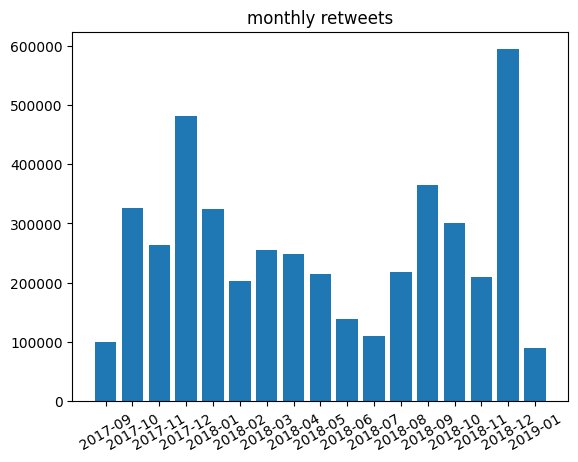

In [21]:
vc = retweet_df['month'].value_counts().sort_index()
months = [str(month)[0:-3] for month in vc.index]
plt.bar(months, vc.values)
plt.title('monthly retweets')
plt.xticks(rotation=30)
plt.show()

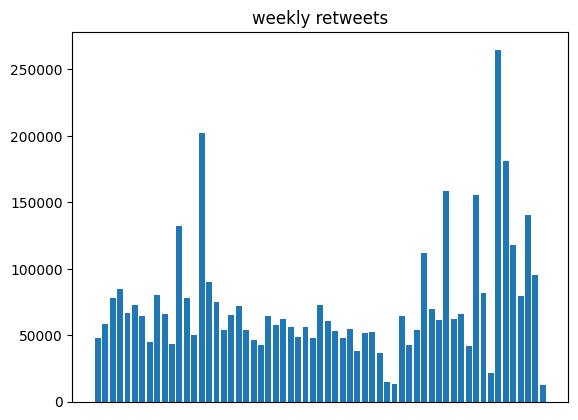

In [22]:
vc = retweet_df['week'].value_counts().sort_index()
weeks = [str(week) for week in vc.index]
plt.bar(weeks, vc.values)
plt.title('weekly retweets')
plt.xticks(ticks=[])
plt.show()

## Getting Leading Users

In [23]:
_, leading_users = dp.get_leading_users(retweet_df, TIMEUNIT, 50, 50)
leading_df = dp.get_only_leading_user_retweets(retweet_df, leading_users, TIMEUNIT, 0)

In [24]:
leading_per_month = len(leading_df[['influencer', 'month']].drop_duplicates())
expected_leading_per_month = len(leading_df['influencer'].unique()) * len(leading_df['month'].unique())
print(f"Avg. Percent of Time Periods a Leading User Persists In: {(leading_per_month / expected_leading_per_month):.0%}")

Avg. Percent of Time Periods a Leading User Persists In: 93%


In [25]:
print(f"{len(leading_df)} ({(len(leading_df) / len(retweet_df)):.0%}) of the retweets are retweeting the leading users (N=50)")
print(f"Leading users represent {(50 / len(retweet_df['influencer'].unique())):.2%} of retweeted individuals total")

894436 (20%) of the retweets are retweeting the leading users (N=50)
Leading users represent 0.03% of retweeted individuals total


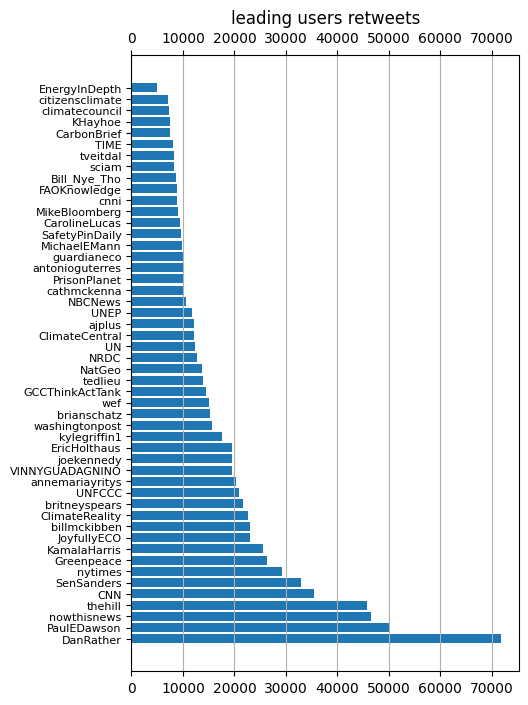

In [26]:
# leading users with smallest audience (this displays retweet count)
vc = leading_df.value_counts('influencer')

plt.figure(figsize=(5,8))
plt.barh(vc.index, vc.values)
plt.title('leading users retweets')
plt.yticks(fontsize=8)
plt.grid(axis='x')
plt.tick_params(top=True, labeltop=True)
plt.show()

## Getting Influencer and Audience Summary Data

In [27]:
leading_summary_df = dp.summarize_tweet_data(leading_df, TIMEUNIT)

print(f"We will be working with {len(leading_df)} retweets from the audience of the {len(leading_df['influencer'].unique())} leading users")
print(f"Time Period for analysis is {leading_df['date'].min()} to {leading_df['date'].max()} in {len(leading_df[TIMEUNIT].unique())} {TIMEUNIT}s")
print(f"There will be {len(leading_summary_df)} rows in the final dataset")

leading_summary_df.head()

We will be working with 894436 retweets from the audience of the 50 leading users
Time Period for analysis is 2017-09-21 to 2019-01-07 in 17 months
There will be 788 rows in the final dataset


,influencer,month,capture,denier,sentiment,male,aggressive,audience_followers,followers,verified,tweet_freq
0,Bill_Nye_Tho,2017-09-01,0.017131,0.000000,0.646136,0.535354,0.000000,544.886364,2.063438e+05,0.0,1.167427
1,CNN,2017-09-01,0.224130,0.000000,-0.159637,0.532137,0.778421,2599.422312,6.060578e+07,0.0,100.720569
2,CarbonBrief,2017-09-01,0.012070,0.322581,0.067314,0.817204,0.003584,4151.594982,1.380509e+05,0.0,22.701842
3,CarolineLucas,2017-09-01,0.000216,0.000000,-0.533246,0.600000,0.000000,4840.400000,6.079236e+05,0.0,10.756467
4,ClimateCentral,2017-09-01,0.040448,0.000000,0.213285,0.645989,0.041711,4439.829947,1.384602e+05,0.0,18.479854


## Getting Audience and Echoer Data

In [28]:
audience_dict = dp.get_audience_dict(leading_df, TIMEUNIT)
echoer_dict = dp.get_echoer_dict(retweet_df, audience_dict, TIMEUNIT)

te.get_tweets(chunk_files, audience_dict).to_pickle('./data/audience.pkl')
te.get_tweets(chunk_files, echoer_dict).to_pickle('./data/echoer.pkl')

In [33]:
audience_df = dp.merge_preprocess_climate_tweets(
    './data/climateTweets.csv',
    './data/audience.pkl',
    start = START,
    end = END,
    retweets=False
)

echoer_df = dp.merge_preprocess_climate_tweets(
    './data/climateTweets.csv',
    './data/echoer.pkl',
    start = START,
    end = END,
    retweets=False
)

In [34]:
final_df = dp.merge_audience_echoer(audience_df, echoer_df, leading_df, retweet_df, TIMEUNIT)

In [39]:
final_df.to_pickle('./final.pkl')
final_df.to_csv('./final.csv')